In [1]:
from datasets import load_dataset
from transformers import BertModel, BertConfig, BertForSequenceClassification, BertTokenizer
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import os

import torch.optim as optim

import matplotlib.pyplot as plt

/home/aix7101/anaconda3/envs/j_knnee/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parameters

#-- setting custom model
total_l = 6
trans_l = 3
base_model = "bert-base-uncased"
model_name = "textattack/bert-base-uncased-QNLI"
 
#-- setting result name
result_name = "qnli_6_3"
model_save_path = f"/mnt/aix7101/jeong/ee/{result_name}.pt"

#-- setting training
train_strategy = "low_lr"  # 'freeze', 'low_lr', 'unfreeze'
num_epoch = 10
num_unfreeze = 3 

In [3]:
db = load_dataset("glue", "qnli")

In [4]:
print(db)

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})


In [5]:
# load train dataset
train_dataset = load_dataset("glue", "qnli", split="train")

# load validation dataset
val_dataset = load_dataset("glue", "qnli", split="validation")

In [6]:
print(val_dataset)

Dataset({
    features: ['question', 'sentence', 'label', 'idx'],
    num_rows: 5463
})


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout = nn.Dropout(p=0.1).to(device) # in BERT default 0.1

In [8]:
# setting

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).eval().to(device)
model.eval()

dropout = nn.Dropout(p=0.1).to(device) # in BERT default 0.1

/home/aix7101/anaconda3/envs/j_knnee/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Custom model

In [9]:
from transformers import BertModel, BertConfig, BertForSequenceClassification
import torch.nn as nn
import torch

class CustomBertSmall(nn.Module):
    def __init__(self, teacher_model, total_layers=6, transplanted_layers=3):
        super().__init__()
        assert transplanted_layers < total_layers, "Transplanted layers must be fewer than total layers"
        
        self.hidden_size = teacher_model.config.hidden_size
        self.total_layers = total_layers
        self.transplanted_layers = transplanted_layers

        # 그대로 복사할 레이어 인덱스 계산
        transplanted_start = 12 - transplanted_layers
        original_layer_indices = list(range(transplanted_start))[:total_layers - transplanted_layers]

        # Embedding 복사
        self.embeddings = teacher_model.bert.embeddings

        # 선택된 layer만 복사해서 재구성
        self.encoder_layers = nn.ModuleList()

        for idx in original_layer_indices:
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        for idx in range(transplanted_start, 12):
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        # Pooler와 Classifier도 복사
        self.pooler = teacher_model.bert.pooler
        self.dropout = teacher_model.dropout  # from classifier head
        self.classifier = teacher_model.classifier

        self.activation = nn.Tanh()  # 여전히 pooler 내부에서도 사용되지만 보존

    # CustomBertSmall에 hidden_states 옵션 추가
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, output_hidden_states=False):
        hidden_states = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

        if attention_mask is not None:
            extended_attention_mask = attention_mask[:, None, None, :]
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        else:
            extended_attention_mask = None

        all_hidden = []  # 각 레이어 출력 저장
        for layer in self.encoder_layers:
            hidden_states = layer(hidden_states, attention_mask=extended_attention_mask)[0]
            if output_hidden_states:
                all_hidden.append(hidden_states)

        pooled_output = self.pooler(hidden_states)
        pooled_output = self.dropout(self.activation(pooled_output))
        logits = self.classifier(pooled_output)

        if output_hidden_states:
            return logits, all_hidden
        else:
            return logits

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = "textattack/bert-base-uncased-ag-news"

teacher_model = BertForSequenceClassification.from_pretrained(base_model, num_labels=2)

small_model = CustomBertSmall(
    teacher_model=teacher_model,
    total_layers=total_l,
    transplanted_layers=trans_l,  # 마지막 l개 레이어 복사
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## [check] before training

In [11]:
# for accuracy with QNLI task
correct_base = 0
correct_small = 0

model.eval()
small_model.eval()

for item in tqdm(val_dataset, desc="Evaluating Small Model (QNLI)"):
    text1 = item["question"]
    text2 = item["sentence"]
    label = item["label"]

    # inputs for sentence pair
    inputs = tokenizer(text1, text2, return_tensors="pt", truncation=True, padding=True).to(device)

    # Teacher model
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
        pred = torch.argmax(logits, dim=-1).item()

    # Small model
    with torch.no_grad():
        small_logits = small_model(**inputs)
        small_pred = torch.argmax(small_logits, dim=-1).item()

    correct_base += int(pred == label)
    correct_small += int(small_pred == label)

# 최종 정확도 출력
total = len(val_dataset)
print(f"\n✅ Accuracy of Bertbase: {correct_base / total * 100:.2f}%")
print(f"\n✅ Accuracy of CustomBertSmall: {correct_small / total * 100:.2f}%")

Evaluating Small Model (QNLI): 100%|██████████| 5463/5463 [01:12<00:00, 75.61it/s]


✅ Accuracy of Bertbase: 91.54%

✅ Accuracy of CustomBertSmall: 49.46%


## Custom Loss

In [12]:
import torch.nn.functional as F
from torch.nn import MSELoss, KLDivLoss

def loss1(logits, labels):
    return F.cross_entropy(logits, labels)

# Representation Matching Loss (MSE between CLS tokens)
def loss2(student_hidden, teacher_hidden):
    mse = MSELoss()
    return mse(student_hidden, teacher_hidden)

# DSR Loss (KL Divergence between sorted logits)
def loss3(prev_logits, current_logits, tau=1.0):
    z_prev = torch.sort(prev_logits, dim=-1)[0]
    z_current = torch.sort(current_logits, dim=-1)[0]

    p_prev = F.softmax(z_prev / tau, dim=-1)
    p_current = F.log_softmax(z_current / tau, dim=-1)

    kldiv = KLDivLoss(reduction='batchmean')
    return (tau ** 2 / 2) * kldiv(p_current, p_prev)  # KL(p_prev || p_current)

In [13]:
import torch
import torch.nn.functional as F

def compute_cka(X: torch.Tensor, Y: torch.Tensor, eps=1e-8):
    X = X - X.mean(dim=0, keepdim=True)
    Y = Y - Y.mean(dim=0, keepdim=True)

    dot_product_similarity = (X.T @ Y).norm(p='fro') ** 2
    normalization_x = (X.T @ X).norm(p='fro')
    normalization_y = (Y.T @ Y).norm(p='fro')
    return dot_product_similarity / (normalization_x * normalization_y + eps)

def cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft):
    delta_t = h_teacher_aft - h_teacher_bef
    delta_s = h_student_aft - h_student_bef
    t = delta_t[:, 0, :]  # CLS
    s = delta_s[:, 0, :]
    return 1 - compute_cka(t, s)

## Train

In [14]:
def evaluate(model, val_loader, tokenizer, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            text1 = batch["question"][0]
            text2 = batch["sentence"][0]
            label = batch["label"].item()

            inputs = tokenizer(text1, text2, return_tensors="pt", padding=True, truncation=True).to(device)
            logits = model(**inputs)
            pred = torch.argmax(logits, dim=-1).item()

            correct += int(pred == label)
            total += 1

    return correct / total * 100

In [15]:
# import torch

# labels = torch.tensor(train_dataset["label"])
# print("Label dtype:", labels.dtype)
# print("Label min:", labels.min().item())
# print("Label max:", labels.max().item())

In [16]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW

def train_custom_model(
    model,
    train_dataset,
    val_dataset,
    tokenizer,
    teacher_model=None,
    custom_loss=False,
    strategy="freeze",
    batch_size=16,
    epochs=10,
    base_lr=5e-5,
    low_lr=5e-6,
    k=3,
    alpha=0.3,
    unfreeze_epoch=1,
    save_path="best_model.pt",
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model = model.to(device)
    if custom_loss and teacher_model is None:
        raise ValueError("teacher_model must be provided when using custom_loss=True")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    if strategy == "low_lr":
        optimizer_grouped = [
            {"params": [p for l in model.encoder_layers[:-k] for p in l.parameters()], "lr": base_lr},
            {"params": [p for l in model.encoder_layers[-k:] for p in l.parameters()], "lr": low_lr},
            {"params": model.pooler.parameters(), "lr": base_lr},
            {"params": model.classifier.parameters(), "lr": base_lr},
        ]
    else:
        optimizer_grouped = model.parameters()

    optimizer = AdamW(optimizer_grouped, lr=base_lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        print(f"\nEpoch {epoch+1}/{epochs}")

        if strategy == "unfreeze" and epoch == unfreeze_epoch:
            print("--<Unfreezing last K layers>--")
            for layer in model.encoder_layers[-k:]:
                for param in layer.parameters():
                    param.requires_grad = True

        for batch in tqdm(train_loader, desc="Training"):
            texts1 = batch["question"]
            texts2 = batch["sentence"]
            labels = batch["label"]

            tokenized = tokenizer(list(texts1), list(texts2), return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in tokenized.items()}
            labels = labels.to(device)

            optimizer.zero_grad()

            if custom_loss:
                logits_small, student_hiddens = model(**inputs, output_hidden_states=True)
                ce_loss = loss_fn(logits_small, labels)

                with torch.no_grad():
                    teacher_outputs = teacher_model(**inputs, output_hidden_states=True)
                    h_teacher_bef = teacher_outputs.hidden_states[(-1)-(k+1)]
                    h_teacher_aft = teacher_outputs.hidden_states[(-1)-k]

                h_student_bef = student_hiddens[(-1)-(k+1)]
                h_student_aft = student_hiddens[(-1)-k]

                cka_loss = cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft)
                loss = ce_loss + alpha * cka_loss
            else:
                logits = model(**inputs)
                loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Avg Training Loss: {avg_loss:.4f}")

        acc = evaluate(model, val_loader, tokenizer, device)
        print(f"Validation Accuracy: {acc:.2f}%")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ New best model saved with accuracy: {best_acc:.2f}% → {save_path}")

In [17]:
train_custom_model(
    model=small_model,
    teacher_model=model,   # 꼭 전달!
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    custom_loss=True,              # ✅ 사용
    alpha=0.3,                     # CKA 가중치
    k=trans_l,
    strategy="train_strategy",
    unfreeze_epoch=num_unfreeze,
    epochs=num_epoch,
    save_path=model_save_path
)


Epoch 1/10


Training: 100%|██████████| 6547/6547 [08:34<00:00, 12.72it/s]


Avg Training Loss: 0.4595


Evaluating: 100%|██████████| 5463/5463 [00:34<00:00, 156.44it/s]


Validation Accuracy: 85.32%
✅ New best model saved with accuracy: 85.32% → /mnt/aix7101/jeong/ee/qnli_6_3.pt

Epoch 2/10


Training: 100%|██████████| 6547/6547 [07:10<00:00, 15.20it/s]


Avg Training Loss: 0.3077


Evaluating: 100%|██████████| 5463/5463 [00:25<00:00, 210.17it/s]


Validation Accuracy: 84.94%

Epoch 3/10


Training: 100%|██████████| 6547/6547 [05:10<00:00, 21.06it/s]


Avg Training Loss: 0.1931


Evaluating: 100%|██████████| 5463/5463 [00:23<00:00, 230.71it/s]


Validation Accuracy: 84.55%

Epoch 4/10


Training: 100%|██████████| 6547/6547 [05:01<00:00, 21.72it/s]


Avg Training Loss: 0.1294


Evaluating: 100%|██████████| 5463/5463 [00:23<00:00, 232.00it/s]


Validation Accuracy: 84.02%

Epoch 5/10


Training: 100%|██████████| 6547/6547 [05:00<00:00, 21.76it/s]


Avg Training Loss: 0.1021


Evaluating: 100%|██████████| 5463/5463 [00:23<00:00, 230.43it/s]


Validation Accuracy: 83.93%

Epoch 6/10


Training: 100%|██████████| 6547/6547 [05:00<00:00, 21.77it/s]


Avg Training Loss: 0.0850


Evaluating: 100%|██████████| 5463/5463 [00:23<00:00, 230.91it/s]


Validation Accuracy: 84.20%

Epoch 7/10


Training: 100%|██████████| 6547/6547 [05:01<00:00, 21.73it/s]


Avg Training Loss: 0.0754


Evaluating: 100%|██████████| 5463/5463 [00:23<00:00, 229.69it/s]


Validation Accuracy: 83.95%

Epoch 8/10


Training: 100%|██████████| 6547/6547 [05:01<00:00, 21.74it/s]


Avg Training Loss: 0.0684


Evaluating: 100%|██████████| 5463/5463 [00:23<00:00, 227.90it/s]


Validation Accuracy: 82.99%

Epoch 9/10


Training: 100%|██████████| 6547/6547 [05:01<00:00, 21.72it/s]


Avg Training Loss: 0.0638


Evaluating: 100%|██████████| 5463/5463 [00:23<00:00, 230.00it/s]


Validation Accuracy: 83.56%

Epoch 10/10


Training: 100%|██████████| 6547/6547 [05:00<00:00, 21.79it/s]


Avg Training Loss: 0.0593


Evaluating: 100%|██████████| 5463/5463 [00:23<00:00, 228.85it/s]

Validation Accuracy: 81.93%


In [18]:
# # 학습 시작
# train_custom_model(
#     model=small_model,
#     train_dataset=train_dataset,
#     val_dataset=val_dataset,
#     tokenizer=tokenizer,
#     strategy=train_strategy,  # 'freeze', 'low_lr', 'unfreeze'
#     epochs=num_epoch,
#     batch_size=16,
#     base_lr=5e-5,
#     low_lr=5e-6,
#     k=2,  # 마지막 3개 레이어를 보존
#     unfreeze_epoch=num_unfreeze,
#     save_path=model_save_path
# )

## [check] after training

In [19]:
# load model

small_model.load_state_dict(torch.load(model_save_path, map_location=device))
small_model = small_model.eval().to(device)


In [20]:
correct_base = 0
correct_small = 0

model.eval()
small_model.eval()

for item in tqdm(val_dataset, desc="Evaluating Small Model on QNLI"):
    question = item["question"]
    sentence = item["sentence"]
    label = item["label"]

    # QNLI는 sentence pair 입력
    inputs = tokenizer(question, sentence, return_tensors="pt", truncation=True, padding=True).to(device)

    # Teacher model (BertForSequenceClassification)
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
        pred = torch.argmax(logits, dim=-1).item()

    # Small model (CustomBertSmall)
    with torch.no_grad():
        small_logits = small_model(**inputs)
        small_pred = torch.argmax(small_logits, dim=-1).item()
    
    correct_base += int(pred == label)
    correct_small += int(small_pred == label)

# 정확도 출력
total = len(val_dataset)
print(f"\n✅ Accuracy of Bertbase: {correct_base / total * 100:.2f}%")
print(f"\n✅ Accuracy of CustomBertSmall: {correct_small / total * 100:.2f}%")

Evaluating Small Model on QNLI: 100%|██████████| 5463/5463 [00:57<00:00, 94.40it/s]


✅ Accuracy of Bertbase: 91.54%

✅ Accuracy of CustomBertSmall: 85.32%


In [21]:
# 정확도 저장 리스트
acc_original = []
acc_small = [0] * total_l  # ✅ small_model의 레이어 수만큼 정확도 저장

for layer in range(1, 13):  # BERT-base: layer 1~12
    correct_orig = 0
    correct_small_by_layer = [0] * total_l  # 각 small layer의 정답 수
    total = 0

    for item in tqdm(val_dataset, desc=f"Layer {layer}"):
        question = item["question"]
        sentence = item["sentence"]
        label = item["label"]

        # QNLI는 sentence pair 입력
        inputs = tokenizer(question, sentence, return_tensors="pt", truncation=True, padding=True).to(device)

        with torch.no_grad():
            # BERT-base layer별 정확도
            outputs = model(**inputs, output_hidden_states=True)
            hidden = outputs.hidden_states[layer]
            pooled = model.bert.pooler(hidden)
            pooled_dropped = dropout(pooled)
            logits_orig = model.classifier(pooled_dropped)
            pred_orig = torch.argmax(logits_orig, dim=-1).item()

            # small model: 전체 forward + hidden states
            logits_small, small_hidden_states = small_model(**inputs, output_hidden_states=True)

            for i, h in enumerate(small_hidden_states):
                pooled_small = small_model.pooler(h)  # CLS 포함
                pooled_small = dropout(pooled_small)
                logits = small_model.classifier(pooled_small)
                pred = torch.argmax(logits, dim=-1).item()
                correct_small_by_layer[i] += int(pred == label)

            correct_orig += int(pred_orig == label)
            total += 1

    acc_original.append(correct_orig / total)

    # 마지막 layer 기준에서 정확도 누적 (1 epoch 끝났을 때만 기록됨)
    if layer == 12:
        acc_small = [c / total for c in correct_small_by_layer]

Layer 12: 100%|██████████| 5463/5463 [01:02<00:00, 87.35it/s]


In [22]:
acc_original

[0.505033864177192,
 0.5055830129965221,
 0.5061321618158521,
 0.5828299469156142,
 0.6734395021050704,
 0.600219659527732,
 0.6690463115504302,
 0.6474464579901154,
 0.6555006406736226,
 0.7777777777777778,
 0.8354384038074318,
 0.9167124290682775]

In [23]:
acc_small

[0.5033864177192019,
 0.5107084019769358,
 0.6879004210140948,
 0.7484898407468424,
 0.8361706022332052,
 0.8498993227164562]

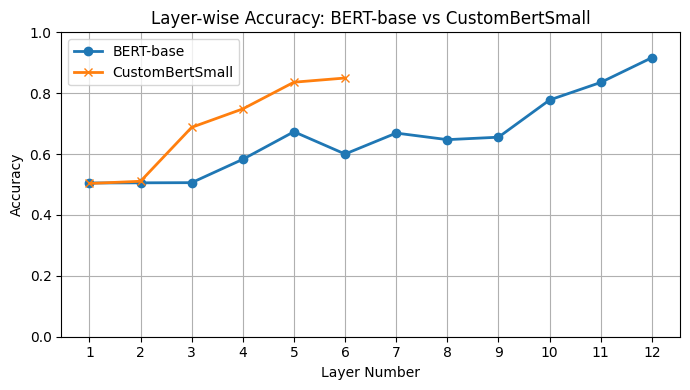

In [25]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 13), acc_original, label="BERT-base", marker='o', linewidth=2)
plt.plot(range(1, total_l + 1), acc_small, label="CustomBertSmall", marker='x', linewidth=2)
plt.xlabel("Layer Number")
plt.ylabel("Accuracy")
plt.title("Layer-wise Accuracy: BERT-base vs CustomBertSmall")
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig(f"/home/aix7101/jeong/ee/ours/codes/img/{result_name}.png", dpi=300)
plt.show()